In [1]:
import numpy as np
from PIL import Image
import os, re, sys
import scipy.spatial.distance
from datetime import datetime
import matplotlib.pyplot as plt
from utils import *

In [2]:
X, X_filename, X_label = readData('./Yale_Face_Database/Training')
test, test_filename, test_label = readData('./Yale_Face_Database/Testing')
data = np.vstack((X, test))
print(data.shape)
filename = np.hstack((X_filename, test_filename))
label = np.hstack((X_label, test_label))
print(filename.shape)
print(label.shape)

(165, 2500)
(165,)
(165,)


In [3]:
def PCA(X, dims):
    mu = np.mean(X, axis=0)
    print(mu.shape)
    cov = (X - mu).T @ (X - mu)
    eigen_val, eigen_vec = np.linalg.eigh(cov)
    print(eigen_vec.shape)
    #eigen_vec = (X - mu).T     @ eigen_vec
    print(eigen_vec.shape)
    for i in range(eigen_vec.shape[1]):
        eigen_vec[:, i] = eigen_vec[:, i] / np.linalg.norm(eigen_vec[:, i])
    idx = np.argsort(eigen_val)[::-1]
    W = eigen_vec[:, idx][:, :dims].real
    print(W)
    return [W, mu]
def LDA(X, label, dims):
    (n, d) = X.shape
    label = np.asarray(label)
    c = np.unique(label)
    mu = np.mean(X, axis=0)
    S_w = np.zeros((d, d), dtype=np.float64)
    S_b = np.zeros((d, d), dtype=np.float64)
    for i in c:
        X_i = X[np.where(label == i)[0], :]
        mu_i = np.mean(X_i, axis=0)
        S_w += (X_i - mu_i).T @ (X_i - mu_i)
        S_b += X_i.shape[0] * ((mu_i - mu).T @ (mu_i - mu))
    eigen_val, eigen_vec = np.linalg.eig(np.linalg.pinv(S_w) @ S_b)
    for i in range(eigen_vec.shape[1]):
        eigen_vec[:, i] = eigen_vec[:, i] / np.linalg.norm(eigen_vec[:, i])
    print(eigen_vec.shape)
    idx = np.argsort(eigen_val)[::-1]
    W = eigen_vec[:, idx][:, :dims].real
    return W

# Part 1

Compute eigenfaces...
(2500,)
(2500, 2500)
(2500, 2500)
[[-0.00042411  0.00393277  0.00940319 ... -0.01449431  0.01111241
  -0.0060926 ]
 [-0.00040258  0.00356202  0.0079007  ... -0.01045945  0.0106258
  -0.00812056]
 [-0.0001522   0.00284927  0.00687755 ... -0.01176082  0.01019781
  -0.00710952]
 ...
 [-0.02727831 -0.01481875 -0.00766347 ...  0.05073863 -0.00695143
  -0.05503843]
 [-0.02700758 -0.0152281  -0.00694427 ...  0.03763389 -0.00852077
  -0.05867811]
 [-0.02699094 -0.01411241 -0.00650205 ...  0.02371333 -0.00449486
  -0.06575733]]
Compute fisherfaces...
(2500, 2500)


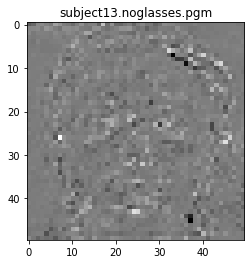

In [4]:
target_idx = np.random.choice(data.shape[0], 10)
target_data = data[target_idx]
target_filename = filename[target_idx]

print('Compute eigenfaces...')
W, mu = PCA(data, 25)
draw(target_data, target_filename, 'pca_eigenface', W, mu)

print('Compute fisherfaces...')
W = LDA(data, label, 25)
draw(target_data, target_filename, 'lda_fisherface', W)

# Part 2

In [ ]:
W, mu = PCA(data, 25)
X_proj = (X - mu) @ W
test_proj = (test - mu) @ W
faceRecognition(X_proj, X_label, test_proj, test_label, 'PCA')

W = LDA(data, label, 25)
X_proj = X @ W
test_proj = test @ W
faceRecognition(X_proj, X_label, test_proj, test_label, 'LDA')